### Parallel simulations

In [1]:
import numpy as np

In [2]:
from dask_quantumtinkerer import Cluster, cluster_options

In [3]:
from codes.parallel import optimize_phase_voltage

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [4]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 10
options.extra_path = "/home/srangaswamykup/trijunction-design/"
cluster_dashboard_link = "http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/"

In [5]:
thickness = [0.5, 1.5]
channel_width = [11.0, 15.0]
gap = [2.0]
angle = [np.pi/6]

In [6]:
from itertools import product

In [7]:
samples = list(product(thickness, channel_width, angle, gap))
samples = list(zip(range(len(samples)), samples)) # add identifier
samples = [[sample[0]] + list(sample[1])  for sample in samples] # unpack second index and make a single list

In [19]:
samples

[[0, 0.5, 11.0, 0.5235987755982988, 1.0],
 [1, 0.5, 11.0, 0.5235987755982988, 3.0],
 [2, 0.5, 15.0, 0.5235987755982988, 1.0],
 [3, 0.5, 15.0, 0.5235987755982988, 3.0],
 [4, 1.5, 11.0, 0.5235987755982988, 1.0],
 [5, 1.5, 11.0, 0.5235987755982988, 3.0],
 [6, 1.5, 15.0, 0.5235987755982988, 1.0],
 [7, 1.5, 15.0, 0.5235987755982988, 3.0]]

In [8]:
import codes.parallel
import importlib
importlib.reload(codes.parallel)

<module 'codes.parallel' from '/home/tinkerer/trijunction-design/analysis/codes/parallel.py'>

In [17]:
samples

[[0, 0.5, 11.0, 0.5235987755982988, 1.0],
 [1, 0.5, 11.0, 0.5235987755982988, 3.0],
 [2, 0.5, 15.0, 0.5235987755982988, 1.0],
 [3, 0.5, 15.0, 0.5235987755982988, 3.0],
 [4, 1.5, 11.0, 0.5235987755982988, 1.0],
 [5, 1.5, 11.0, 0.5235987755982988, 3.0],
 [6, 1.5, 15.0, 0.5235987755982988, 1.0],
 [7, 1.5, 15.0, 0.5235987755982988, 3.0]]

#### Adaptive sampling

In [30]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant
from dask_quantumtinkerer import Cluster, cluster_options
import adaptive

import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.system_functions import diagonalisation, adaptive_two_parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index, order_wavefunctions
from codes.constants import sides

In [2]:
pairs = ['right-top', 'left-top', 'left-right']

In [3]:
from scipy.optimize import minimize, minimize_scalar

In [4]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
      {"device":
     {"grid_spacing":
      {"twoDEG": 0.5, "normal": 1, "dielectric": 1, "air": 5, "gate": 1, "substrate": 1}}},
    {"gate": {"channel_width": 13.0, "L":40, 'angle': np.pi/6, 'gap': 4}},
    # {"kwant": {'nww': 8}}
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [5]:
system = trijunction.Trijunction(config, optimize_phase_pairs=[])

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:30<00:00,  2.34s/it]


# Phase exploration 

In [6]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 2
options.extra_path = "/home/srangaswamykup/trijunction-design/"

In [7]:
# prepare arguments
phis = np.linspace(0, 2, 50) * np.pi
phases = {}

for pair in pairs:
    phases[pair] = [parameters.phase_pairs(pair, phi) for phi in phis]

In [23]:
voltages = parameters.pair_voltages(initial=(-3.3e-3, -3.3e-3, -3.3e-3, 3e-2), 
                                    depleted=-7e-3)

In [24]:
# fixed voltage matrices
fixed_linear_matrices = [
    sum(
        [volts[key] * system.linear_terms[key] for key in system.linear_terms.keys()]
    ) for volts in voltages.values()
]

In [25]:
cluster_dashboard_link = "http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/"
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())

with Cluster(options) as cluster:
    cluster.scale(n=50)
    client = cluster.get_client()
    client.wait_for_workers(1)
    print(cluster_dashboard_link + cluster.dashboard_link[17:])
    scattered_trijunction = client.scatter(system.trijunction, broadcast=True)
    scattered_f_params = client.scatter(system.f_params, broadcast=True)
    scattered_linear_terms = client.scatter(fixed_linear_matrices, broadcast=True)

    for i, pair in enumerate(pairs):
        futures = client.map(
            diagonalisation,
            phases[pair],
            trijunction=scattered_trijunction,
            f_params=scattered_f_params,
            linear_terms=scattered_linear_terms[i],
            params=params
        )
        phase_relations[pair] = client.gather(futures)

http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/8000/clusters/d03eb39d26b840509032448e774cf8cc/status


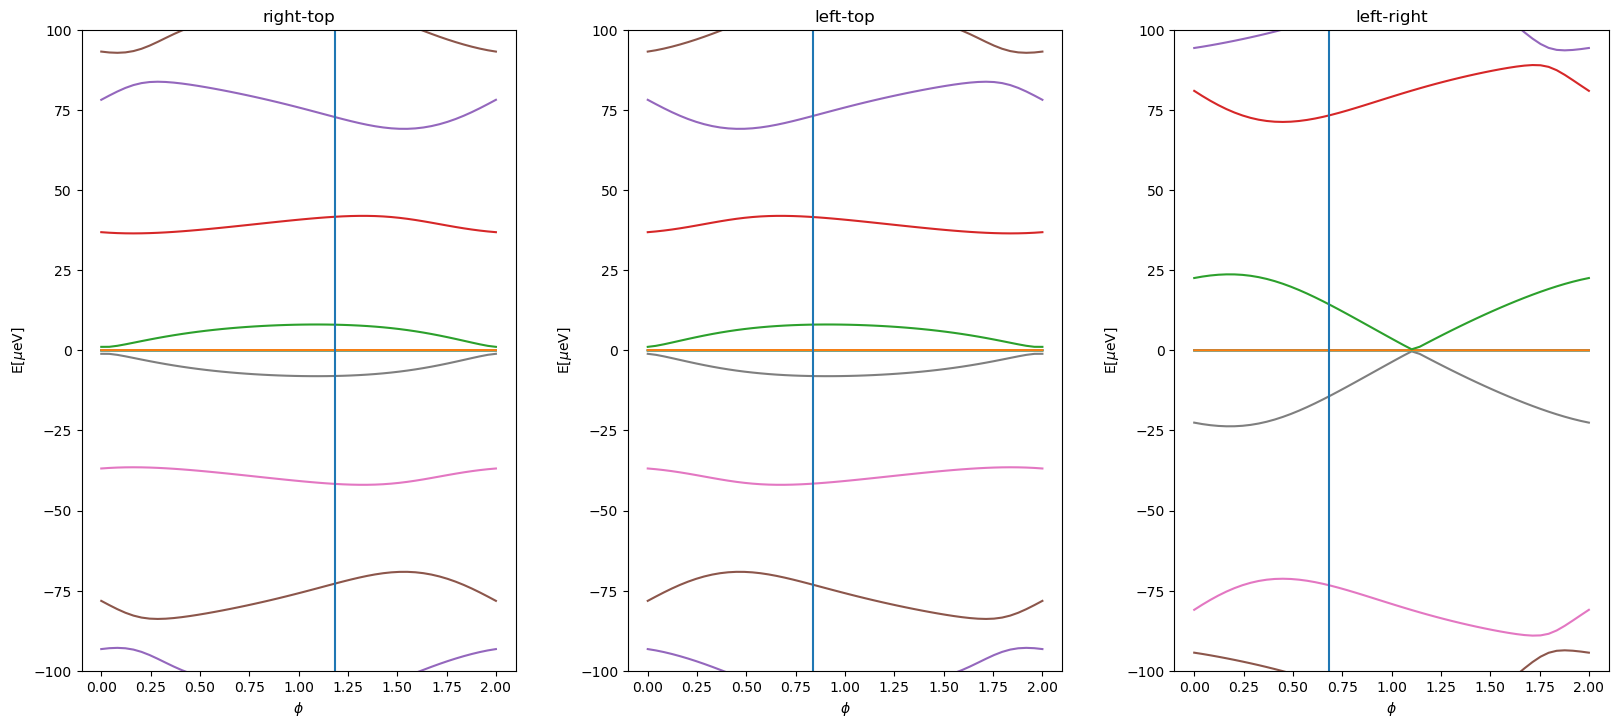

In [55]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 7))
fig.tight_layout(w_pad=5)

for i, pair in enumerate(pairs):

    phase = 1e6*np.array(phase_relations[pair])

    axes[i].set_title(pair)
    axes[i].set_xlabel(r'$\phi$')
    axes[i].set_ylabel(r'E[$\mu$eV]')

    axes[i].plot(phis/np.pi, phase)
    axes[i].set_ylim(-100, 100)
    opt_phase = optimal_phases[pair]/np.pi
    axes[i].vlines(opt_phase, ymin=-np.max(phase), ymax=np.max(phase))

## Voltage exploration 

In [28]:
plunger_min = -5e-3
plunger_max = 0

bounds = [
    (plunger_min, plunger_max),
    (plunger_min, plunger_max),
]

In [32]:
pair = 'right-top'

params = parameters.junction_parameters()
params.update(potential=system.flat_potential())

index = system.indices.copy()

# remove 50% of the points from the channel to be depleted that is closest to the center.
depleted_channel = list(set(sides)-set(pair.split('-')))[0]
depleted_indices = index[depleted_channel]
index[depleted_channel]  = depleted_indices[:int(len(depleted_indices)*50/100)]

params['dep_acc_index'] = index

args = (pair.split('-'),
        (system.base_ham, system.linear_terms),
        params['dep_acc_index'], 
        )

initial_condition = (-3e-3, -3e-3, -3e-3, 3e-3)

sol1 = minimize(optimization.shape_loss, 
         x0=initial_condition, 
         args=args, 
         method='trust-constr', 
         options={'initial_tr_radius':1e-3}
        )

In [36]:
def call_loss(xy,
              x0,
              pair, 
              base_ham, 
              base_params, 
              linear_terms, 
              # f_params, 
              # mlwf
             ):

            
    # ci, weights = 50, [1, 1e1]
#     args = ((base_ham, 
#             base_params, 
#             linear_terms, 
#             f_params, 
#              mlwf[order_wavefunctions(pair)]),
#             (pair.split('-'), ci, weights)
#            )
    
    args = (pair.split('-'),
        (base_ham, linear_terms),
         base_params['dep_acc_index'], 
        )

    for i, arm in enumerate(pair.split('-')):
        x0[np.where(np.array(sides) == arm)] = xy[i]
    
    return optimization.shape_loss(x0, *args)

In [37]:
cluster_dashboard_link = "http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/"
params = parameters.junction_parameters()
params.update(potential=system.flat_potential())

index = system.indices.copy()

# remove 50% of the points from the channel to be depleted that is closest to the center.
depleted_channel = list(set(sides)-set(pair.split('-')))[0]
depleted_indices = index[depleted_channel]
index[depleted_channel]  = depleted_indices[:int(len(depleted_indices)*50/100)]

params['dep_acc_index'] = index

In [38]:
cluster = await Cluster(options, asynchronous=True)

await cluster.scale(50)
client = await cluster.get_client()
await client.wait_for_workers(1)
print(cluster_dashboard_link+cluster.dashboard_link[17:])

http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/8000/clusters/e9b7f64b8b764cf590191f8767dae9e5/status


In [39]:
pair = 'right-top'

In [40]:
scattered_base_ham = await client.scatter(system.base_ham, broadcast=True)
scattered_linear_matrices = await client.scatter(system.linear_terms, broadcast=True)

In [41]:
async def f_async(xy):
    future = client.submit(
          call_loss,
          xy,
          x0 = [-3e-3, -3e-3, -3e-3, 3e-3],
          pair=pair, 
          base_ham=scattered_base_ham, 
          base_params=params, 
          linear_terms=scattered_linear_matrices,
    )

    return await future

In [42]:
learner = adaptive.Learner2D(f_async, bounds=bounds)

In [43]:
runner = adaptive.AsyncRunner(
    learner,
    goal=lambda l: l.loss() < 0.001,
    ntasks=199
)

In [44]:
_, _, z = learner.interpolated_on_grid()

ValueError: No points given

Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/opt/conda/lib/python3.10/ssl.py", line 1342, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLEOFError: EOF occurred in violation of protocol (_ssl.c:997)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 696, in _handle_events
    self._handle_read()
  File "/opt/conda/lib/python3.10/site-packages/tornado/iostream.py", line 1478, in _handle_read
    self._do_ssl_han

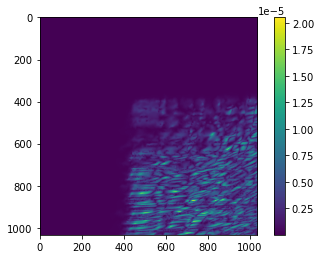

In [56]:
plot = plt.imshow(z)
plt.colorbar(plot)